<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# Загружаем библиотеки
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import warnings
import winsound

warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
tqdm.pandas()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Евгений П\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Евгений
[nltk_data]     П\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Загрузим данные
# df=pd.read_csv('toxic_comments.csv')
df=pd.read_csv('/datasets/toxic_comments.csv')
df.info()
# df = df.sample(10000).reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [3]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
# Удалим ненужный нам столбец 'Unnamed: 0'
df = df.drop('Unnamed: 0', axis=1)

In [5]:
# Удалим строки с пропусками
df = df.dropna()

In [6]:
# Проверим на наличие явных дубликатов
df.duplicated().sum()

0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


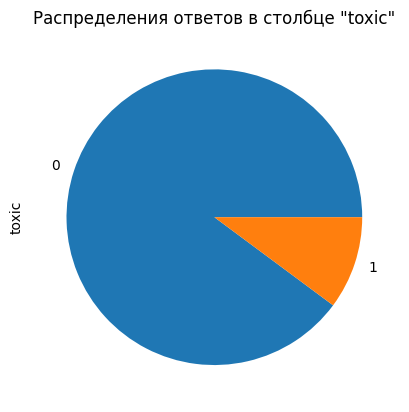

In [8]:
# Проанализируем распределение отзывов на твиты в нашем датасете
df['toxic'].value_counts(normalize=True).plot(kind='pie')
plt.title('Распределения ответов в столбце "toxic"')
plt.show()

Имеем сильный дисбаланс. Учтём это при дальнейшем обучении.

In [9]:
# Функция РОS-тэгирования слов:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,               #прилагательное
                "N": wordnet.NOUN,              #существительное
                "V": wordnet.VERB,              #глагол
                "R": wordnet.ADV                #наречие
               }  
    return tag_dict.get(tag, wordnet.NOUN)


# Лемматизируем текст
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    text = text.lower()
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', text)
    lemm_text = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in cleared_text.split()])
    return lemm_text


df['lemm_text'] = df['text'].progress_apply(lemmatize_text)

winsound.Beep(440, 500)

100%|████████████████████████████████████████████████████████████████████████| 159292/159292 [1:31:10<00:00, 29.12it/s]


In [11]:
df['lemm_text'][0]

'explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now'

In [12]:
# Выделим целевые значения и признаки
features = df['lemm_text']
target = df['toxic']

In [13]:
# Разделим данные на обучающую и тестовую выборки.
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=True, test_size=0.25, random_state=12345, stratify=target)

Отфильтруем содержимое при помощи библиотеки nltk

In [14]:
nltk.download('stopwords') 
stop_words = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Евгений
[nltk_data]     П\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Выполним векторизацию текстов с помощью TfidfVectorizer

In [15]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words) 

count_tf_idf.fit(features_train)
features_train = count_tf_idf.transform(features_train)

features_test = count_tf_idf.transform(features_test)

In [16]:
print(features_train.shape)

(119469, 127493)


In [17]:
print(features_test.shape)

(39823, 127493)


**Выводы**

В данном разделе мы загрузили все необходимые библиотеки, загрузили данные (159292 строк). Удалили неинформативный столбец "Unnamed: 0". Проверили датасет на наличие строк с пропусками данных, на наличие явных дубликатов. Отобразив ответы в графе "Toxic" на круговой диаграмме, стало ясно, что имеется сильный дисбаланс классов в ответах. Пока с ним бороться не будем, учтём это при работе с моделями. Применили функцию РОS-тэгирования слов и лемматизировали тексты. Далее из данных выделили целевые значения и признаки, разделили данные на обучающую и тестовую выборки. Отфильтровали содержимое при помощи библиотеки nltk, выполнили векторизацию текстов с помощью TfidfVectorizer. Данные готовы к дальнейшему обучению моделей.

## Обучение

**I. Логистическая регрессия**

In [21]:
%%time
model_lr = LogisticRegression(random_state=12345, class_weight='balanced', n_jobs=-1)
score_lr = cross_val_score(model_lr, features_train, target_train, scoring='f1',cv=3).mean()
print('F1:',score_lr)
winsound.Beep(440, 500)

F1: 0.7422274779800434
CPU times: total: 281 ms
Wall time: 15.2 s


F1=0,74

**II. Дерево решений**

In [22]:
%%time
model_dtc= DecisionTreeClassifier(random_state=12345)
param_grid = {"max_depth" : range(92,95)}
gsearch_dtc = GridSearchCV(model_dtc, param_grid = param_grid, n_jobs=-1, scoring='f1', cv=3)
dtc_model = gsearch_dtc.fit(features_train, target_train)
print(f'Лучшая F1: {dtc_model.best_score_} при параметрах {dtc_model.best_params_}')
winsound.Beep(440, 500)

Лучшая F1: 0.7183571355738664 при параметрах {'max_depth': 93}
CPU times: total: 47.4 s
Wall time: 4min 31s


Лучшая F1: 0.72 при параметрах {'max_depth': 93}

**III. Случайный лес**

In [23]:
%%time
model_rfc= RandomForestClassifier(random_state=12345, n_jobs=-1, class_weight='balanced')
param_grid = {"max_depth" : range(268,269), "n_estimators" : range(51,52)}
gsearch_rfc = GridSearchCV(model_rfc, param_grid = param_grid, n_jobs=-1, scoring='f1', cv=3)
rfc_model = gsearch_rfc.fit(features_train,target_train)
print(f'Лучшая F1: {rfc_model.best_score_} при параметрах ,{rfc_model.best_params_}')
winsound.Beep(440, 500)

Лучшая F1: 0.5880751985254324 при параметрах ,{'max_depth': 268, 'n_estimators': 51}
CPU times: total: 5min 18s
Wall time: 11min 11s


Лучшая F1: 0.59 при параметрах ,{'max_depth': 268, 'n_estimators': 51}

**IV. LGBMClassifier**

In [27]:
%%time
model_lgbm = LGBMClassifier(random_state=12345, n_jobs=-1, learning_rate=0.24, is_unbalance=True, force_col_wise=True)
param_grid = {
    'learning_rate' : np.arange(0.21, 0.23, 0.01),
    'boosting_type' : ['gbrt', 'goss'],
    'max_depth' : range(22,25)
}
gsearch = GridSearchCV(model_lgbm, param_grid = param_grid, n_jobs=-1, scoring='f1', cv=3)
lgbm_model = gsearch.fit(features_train,target_train)
print(f'Лучшая метрика: {lgbm_model.best_score_} при параметрах ,{lgbm_model.best_params_}')
winsound.Beep(440, 500)

Лучшая метрика: 0.7446590573824969 при параметрах ,{'boosting_type': 'gbrt', 'learning_rate': 0.22, 'max_depth': 23}
CPU times: total: 54.9 s
Wall time: 1h 9min 34s


Лучшая F1: 0.74 при параметрах ,{'boosting_type': 'gbrt', 'learning_rate': 0.22, 'max_depth': 23}

In [28]:
# Запишем данные всех моделей вместе
models = []
models.append([0.74])
models.append([0.72])
models.append([0.59])
models.append([0.74])
model_table = pd.DataFrame(data=models, index=['Логистическая регрессия', 'Дерево решений', 'Случайный лес', 'LGBMClassifier'],
                           columns=['Метрика F1'])
model_table

,Метрика F1
Логистическая регрессия,0.74
Дерево решений,0.72
Случайный лес,0.59
LGBMClassifier,0.74


**Промежуточный вывод**

Мы обучили четыре модели, и для каждой измерили метрику F1. Наилучшие результаты показали модели: Логистическая регрессия и LGBMClassifier. Но Логистическая регрессия имеет в разы лучшее быстродействие, поэтомувыбор остановим на ней. Проверим её на тестовой выборке:

In [29]:
# Проверим лучшую модель на тестовой выборке
best_model = LogisticRegression(random_state=12345, class_weight='balanced', n_jobs=-1)
best_model.fit(features_train, target_train)
predictions = best_model.predict(features_test)
print('F1 модели LogisticRegression на тестовой выборке:', f1_score(target_test, predictions))

F1 модели LogisticRegression на тестовой выборке: 0.7466551575312904


## Выводы

Поставленная перед нами цель: подобрать модель для магазина "ВИКИШОП", которая способна классифицировать комментарии на позитивные и негативные для того, чтобы в дальнейшем токсичные отзывы отправлялись на модерацию. При этом достигуть результата предсказания наилучшей модели по метрике качества F1 не ниже 0,75.

Для определения наилучшей модели обучались модели LogisticRegression, DecisionTreeClassifier, RandomForestClassifier и LGBMClassifier. По итогам сравнеиня победила модель LogisticRegression, после проверки на тестовой выборке её значение F1 составило 0,75.
Мы справились с поставленной задачей и можем рекомендовать к использованию в работе данную модель.